In [2]:
import matplotlib.pyplot as plt
import numpy as np
import processes_lib as pr
import random
import time

In [2]:
vel_dist = pr.vel_dist

Latitude = random.uniform(-np.pi/2, np.pi/2)
Longitude = random.uniform(0, np.pi*2)
tod = round(random.uniform(6, 18), 2)

R_bar = pr.R/(pr.m_H2O/1000)

# establish arrays and basics to run
i=0
dist_tot = 0
tof_tot = 0

f_lat = Latitude
f_long = Longitude
f_tod = tod

st = time.time()
Temperature, n = pr.DivinerT_v2(f_lat, f_long, f_tod, pr.data)
en = time.time()
print('divier', en-st)

# surface residence time
st = time.time()
f_tod, Temperature, tau_surf, sat_t, cond_c = pr.rot_moon(f_tod, Temperature, R_bar, pr.mass, f_lat, f_long)
en = time.time()
print('rot moon', en-st)

time_tot = sat_t*pr.sec_per_hour_M

st = time.time()
cond_s = pr.loss(pr.sput_lifespan_G19, pr.photo_lifespan_S14, tau_surf)
en = time.time()
print('loss', en-st)

cond_j = False

while cond_j == False and cond_s == False and cond_c == False:
    # particle jump
    direction, launch = pr.random_vals() 
    Temperature, n = pr.DivinerT_v2(f_lat, f_long, f_tod, pr.data)
    f_lat, f_long, f_tod, f_tof, distm = pr.ballistic(Temperature, f_lat, f_long, f_tod, direction, launch, pr.mass, vel_dist)

    # record of total
    dist_tot += distm
    tof_tot += f_tof

    # is it lost in jump? 
    cond_j = pr.loss(pr.sput_lifespan_G19, pr.photo_lifespan_S14, f_tof)

    # surface sit, update time of day
    f_tod, Temperature, tau_surf, sat_t, cond_c  = pr.rot_moon(f_tod, Temperature, R_bar, pr.mass, f_lat, f_long)

    #f_tod += tau_surf
    time_tot += (sat_t*pr.sec_per_hour_M + f_tof)

    # is it lost from the surface?      
    cond_s = pr.loss(pr.sput_lifespan_G19, pr.photo_lifespan_S14, tau_surf) # this isn't handling surface times right. 

    i+=1


divier 0.4606297016143799
rot moon 0.000179290771484375
loss 0.0001468658447265625
Molecule sits on surface for 2.5, so Moon rotates from 6.882 to 9.382 hr 
Molecule sits on surface for 1.0, so Moon rotates from 6.862 to 7.862 hr 
Molecule sits on surface for 3.0, so Moon rotates from 6.445 to 9.445 hr 
Lost to photodestruction


In [3]:
import time
st = time.time()

ln = 10

runTime = np.zeros((ln))
out = np.zeros((ln, 6))

for i in range(0, ln):
    start = time.time()
    Latitude = random.uniform(-np.pi/2, np.pi/2)
    Longitude = random.uniform(0, np.pi*2)
    tod = round(random.uniform(6, 18), 2)
    out[i] = pr.Model_v3(tod, Latitude, Longitude, pr.sput_lifespan_G19, pr.photo_lifespan_S14, pr.mass, pr.data)
    end = time.time()
    runTime[i] = end - start
    
    if i %1 == 0:
        print(i, runTime[i], np.sum(runTime[0:i+1]))
        print(np.rad2deg(Latitude), np.rad2deg(Longitude), tod)
en = time.time()
print('Time: %4.2f s'%(en-st))

Molecule sits on surface for 10.0, so Moon rotates from 20.962 to 6.962 hr 
Lost to photodestruction
0 60.982523918151855 60.982523918151855
81.61969937080256 183.10432835691148 13.2
Molecule sits on surface for 2.0, so Moon rotates from 5.405 to 7.405 hr 
Molecule sits on surface for 1.0, so Moon rotates from 6.301 to 7.301 hr 
Molecule sits on surface for 1.5, so Moon rotates from 5.833 to 7.333 hr 
Molecule sits on surface for 13.0, so Moon rotates from 18.459 to 7.459 hr 
Molecule sits on surface for 3.5, so Moon rotates from 6.201 to 9.701 hr 
Molecule sits on surface for 13.5, so Moon rotates from 18.853 to 8.353 hr 
Molecule sits on surface for 2.0, so Moon rotates from 7.187 to 9.187 hr 
cold trapped
Molecule sits on surface for 24.5, so Moon rotates from 18.872 to 19.372 hr 


ValueError: Sample larger than population or is negative

11.56358289718628 307.8605988025665 124.41787691116333


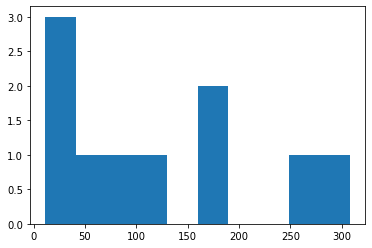

In [5]:
plt.hist(runTime)
print(min(runTime), max(runTime), np.mean(runTime))

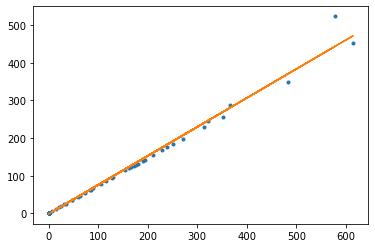

0.7691225906806821 -1.1897313572371218
10 jump run takes 6.50
100 jump run takes 75.72
1000 jump run takes 767.93


In [7]:
# plot above stuff
a, b = np.polyfit(j, runTime, 1)
plt.plot(j, runTime, '.')
plt.plot(j, a*j + b)
plt.show()

print(a, b)
print("10 jump run takes %3.2f"%(a*10+b))
print("100 jump run takes %3.2f"%(a*100+b))
print("1000 jump run takes %3.2f"%(a*1000+b))

In [ ]:
def DivinerT(lat_R, long_R, tod, delta, data):
    lat = np.rad2deg(lat_R)
    long = np.rad2deg(long_R - np.pi) 
    print(lat, long)
    masklong = (data[:, :, 0] > long - delta) & (data[:, :, 0] < long+delta)
    masklat = (data[:, :, 1] > lat - delta) & (data[:, :, 1] < lat+delta)
    if tod < delta/2:
        masktod = (data[:, :,  2] > (tod - delta)%24 ) | (data[:, :, 2] < (tod+delta)%24)
    elif tod > 24-delta/2:
        masktod = (data[:, :,  2] > (tod - delta)%24 ) | (data[:, :, 2] < (tod+delta)%24)
    else:            
        masktod = (data[:, :,  2] > (tod - delta)) & (data[:, :, 2] < (tod+delta))
    
    row = masklong*masklat*masktod
    if np.any(row) != True:
        print(lat)
        raise Exception("Lacking lat data")
    else: 
       T = data[row, 10]
       n = np.size(T[~np.isnan(T)])
       if np.all(np.isnan(T)) == True:
           print(lat, long, tod, T)
           print(lat_R, long_R)
           raise Exception("all nans")
       Tmean = np.nanmean(T)

    return Tmean, n, T

lat_R = np.deg2rad(0.25)
long_R = np.deg2rad(179.25)
tod = 1

mean, n, t = DivinerT(lat_R, long_R, tod, delta, data)


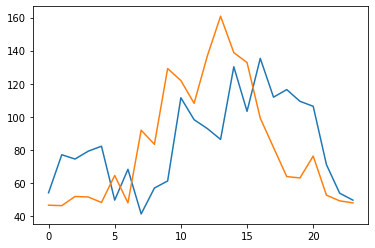

[ 42.1548 132.854   88.1395  75.2727  48.3296  62.535   36.7341  45.0568
  43.1517  50.2317  83.0911  47.6419  48.7098  61.4573 151.0993 116.796
 159.8293 141.0252 181.0157 155.1835 150.677  102.6158  51.4333  63.2931]
[42.1548 80.6804 46.5669 46.8503]
42.1548 80.6804 54.063100000000006 15.479872144659339 46.7086
36.7341 115.0364 68.26214999999999 29.848279531197438
48.7098 134.1445 92.893225 39.10490082709423
60.2562 181.0157 116.44895 55.01503763919916


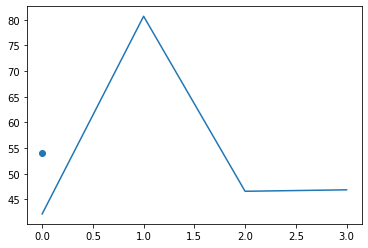

In [39]:
plt.plot(tod, Tmean)
plt.plot(tod, Tmean_180)
plt.show()

print(T[:, 0])
print(T[0, :])

print(np.min(T[0, :]), np.max(T[0, :]), np.mean(T[0, :]), np.std(T[0, :]), np.median(T[0, :]))
print(np.min(T[6, :]), np.max(T[6, :]), np.mean(T[6, :]), np.std(T[6, :]))
print(np.min(T[12, :]), np.max(T[12, :]), np.mean(T[12, :]), np.std(T[12, :]))
print(np.min(T[18, :]), np.max(T[18, :]), np.mean(T[18, :]), np.std(T[18, :]))

plt.plot(T[0, :])
plt.scatter(0, Tmean[0])

0 132.5819375 12
0 132.5819375 5.900090919473749
0 132.5819375 5.900090919473749
1 60.43439629629629 6.736006635896171
Molecule sits on surface for 3.5, so Moon rotates from 6.736 to 10.236 hr 
1 122.7836740740741 10.236006635896171
2 122.7836740740741 10.859125776871831
2 122.7836740740741 10.859125776871831
3 181.072012962963 8.566651378909693
3 181.072012962963 8.566651378909693
4 123.87466111111111 7.81966750021169
4 123.87466111111111 7.81966750021169
5 152.47790588235293 6.037279012766242
5 152.47790588235293 6.037279012766242
6 53.50356041666665 5.773065433446364
Molecule sits on surface for 3.0, so Moon rotates from 5.773 to 8.773 hr 
6 148.33016249999997 8.773065433446364
7 148.33016249999997 7.505276569188387
7 148.33016249999997 7.505276569188387
8 152.72040185185185 6.637008382969252
8 152.72040185185185 6.637008382969252
9 102.91954583333334 6.68661351891817
Molecule sits on surface for 1.0, so Moon rotates from 6.687 to 7.687 hr 
9 128.03528541666665 7.68661351891817
10 1

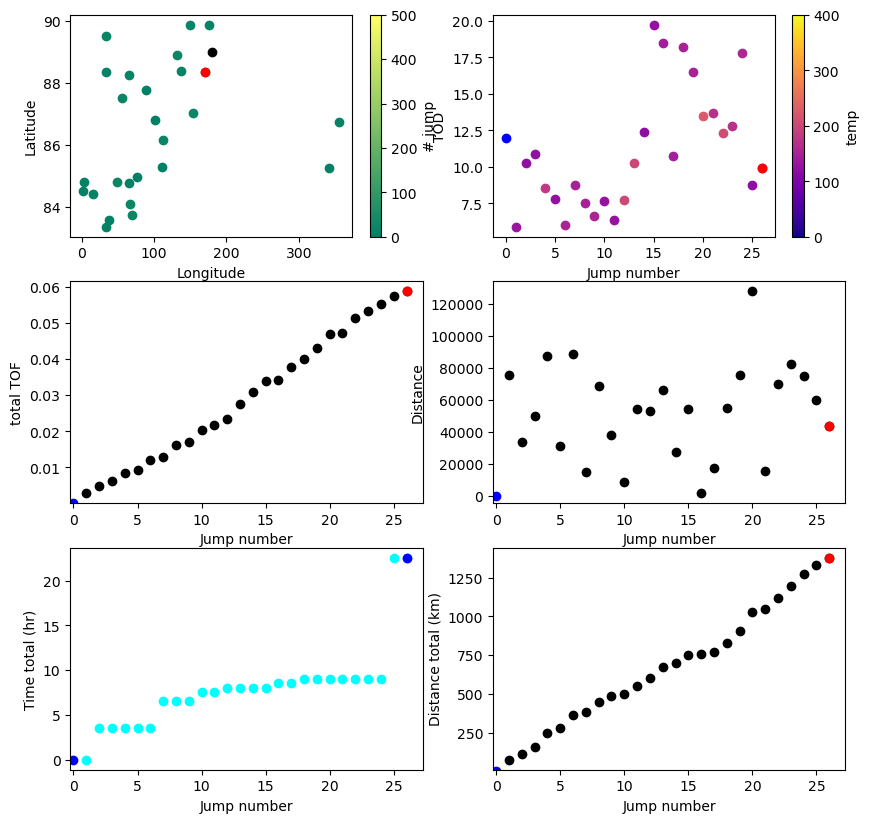

Run time: 53.17


In [4]:
start = time.time()
fig, ax = plt.subplots(3, 2, figsize=(10, 10), dpi=100)

R_bar = pr.R/(pr.m_H2O/1000)

# establish arrays and basics to run
i=0
dist_tot = 0
tof_tot = 0
f_lat = np.deg2rad(89)
f_long = np.pi
f_tod = 12

Temperature = pr.DivinerT(f_lat, f_long, f_tod, 0.75, pr.data)

ax[0, 0].scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c='k')
ax[0, 1].scatter(i, f_tod, c='b')
ax[1, 0].scatter(i, 0, c='b')
ax[1, 1].scatter(i, 0, c='b')
ax[2, 0].scatter(i, tof_tot, c='b')
ax[2, 1].scatter(i, dist_tot, c='b')

# surface residence time
f_tod, Temperature, tau_surf, sat_t = pr.rot_moon(f_tod, Temperature, R_bar, pr.mass, f_lat, f_long)

time_tot = sat_t*pr.sec_per_hour_M

cond_s = pr.loss(pr.sput_lifespan_G19, pr.photo_lifespan_S14, tau_surf)
cond_j = False


while cond_j == False and cond_s == False:
    # particle jump
    direction, launch = pr.random_vals() 
    Temperature = pr.DivinerT(f_lat, f_long, f_tod, 0.75, pr.data)
    f_lat, f_long, f_tod, f_tof, distm = pr.ballistic(Temperature, f_lat, f_long, f_tod, direction, launch, pr.mass, pr.vel_dist)
    
    # record of total
    dist_tot += distm
    tof_tot += f_tof

    # is it lost in jump? 
    cond_j = pr.loss(pr.sput_lifespan_G19, pr.photo_lifespan_S14, f_tof)

    # surface sit, update time of day
    f_tod, Temperature, tau_surf, sat_t = pr.rot_moon(f_tod, Temperature, R_bar, pr.mass, f_lat, f_long)
    
    #f_tod += tau_surf
    time_tot += (sat_t*pr.sec_per_hour_M + f_tof)

    # is it lost from the surface?      
    cond_s = pr.loss(pr.sput_lifespan_G19, pr.photo_lifespan_S14, tau_surf)

    i+=1

    if i%20 == 0:
        print(i)
    
    cf = ax[0, 0].scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c=i, cmap='summer', vmin=0, vmax=500)
    cf2 = ax[0, 1].scatter(i, f_tod, c=Temperature, cmap='plasma', vmin=0, vmax=400) #c='k')
    ax[1, 0].scatter(i, tof_tot/pr.sec_per_hour_M, color='k')
    ax[1, 1].scatter(i, distm, c='k')
    #ax[2, 0].scatter(i, tof_tot/pr.sec_per_hour_M, c='k') #tau_surf, c='k')
    ax[2, 0].scatter(i, time_tot/pr.sec_per_hour_M, c='cyan')
    ax[2, 1].scatter(i, dist_tot/1000, c='k')

    
    #limit runs
    if i == 50:
        cond_s = True
    
ax[0, 0].scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c='r')
ax[0, 0].set_ylabel('Latitude')
#ax[0, 0].set_ylim((-90, 90))
ax[0, 0].set_xlabel('Longitude')
#ax[0, 0].set_xlim((0, 360))
fig.colorbar(cf, ax=ax[0, 0], label='# jump')

ax[0, 1].scatter(i, f_tod, c='r')
ax[0, 1].set_ylabel('TOD')
ax[0, 1].set_xlabel('Jump number')
fig.colorbar(cf2, ax=ax[0, 1], label='temp')

ax[1, 0].scatter(i, tof_tot/pr.sec_per_hour_M, color='r')
#ax[1, 0].scatter(i, f_tof, color='r')
ax[1, 0].set_ylabel('total TOF')
ax[1, 0].set_xlabel('Jump number')

ax[1, 1].scatter(i, distm, c='r')
ax[1, 1].set_ylabel('Distance')
ax[1, 1].set_xlabel('Jump number')

#ax[2, 0].scatter(i, tof_tot/pr.sec_per_hour_M, color='r')
ax[2, 0].scatter(i, time_tot/pr.sec_per_hour_M, color='b')
ax[2, 0].set_ylabel('Time total (hr)')
ax[2, 0].set_xlabel('Jump number')

ax[2, 1].scatter(i, dist_tot/1000, c='r')
ax[2, 1].set_ylabel('Distance total (km)')
ax[2, 1].set_xlabel('Jump number')

plt.show()

end = time.time()
print("Run time: %3.2f"%(end-start))

In [ ]:
tod = 23
Latitude = 0
Longitude = 0


i, f_lat, f_long, f_tod, dist_tot, tof_tot = pr.Model_v2(tod, Latitude, Longitude, pr.sput_lifespan_G19, pr.photo_lifespan_S14, pr.mass, pr.data)


In [4]:
print(Latitude, Longitude, tod)
print(i)
print(np.rad2deg(f_lat), np.rad2deg(f_long), f_tod, dist_tot, tof_tot)
print(tof_tot/pr.sec_per_hour_M)
print(pr.DivinerT(f_lat, f_long, f_tod, 0.75, pr.data))

0 0 23
200
21.96748502079191 336.8338354977666 5.979720277757022 14514334.801070996 55719.34434802326
0.5241312445725934
163.28958484848485


(74, 8)
(74,)


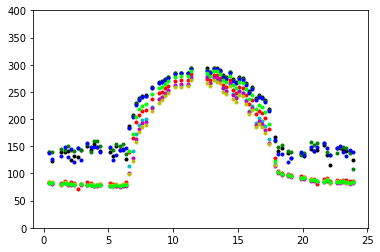

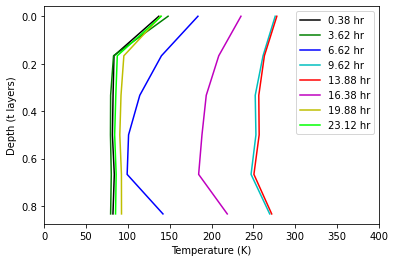

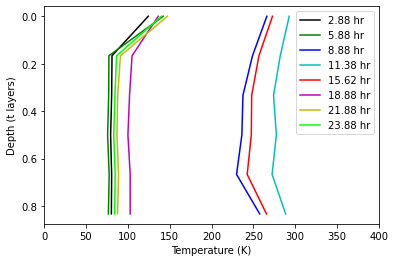

In [2]:
# if each row is some T at depth, then take all of them for a specific point, across times of day, and plot
mask = (pr.data[:, :, 1] > 70.2) & (pr.data[:, :, 1] <= 70.3)& (pr.data[:, :, 0] > 0.2) & (pr.data[:, :, 0] <= 0.3) # latitude and long limited

latitude = pr.data[:, :, 1][mask]
longitude = pr.data[:, :, 0][mask]

err = pr.data[:, :, 3][mask] != -9999

temp = np.abs(pr.data[:, :, 3:][mask][err])
print(np.shape(temp))

#mask_tod = (pr.data[mask, 2] < 12.5) & (pr.data[mask, 2] > 11.5)

tod = pr.data[mask, 2][err]
print(np.shape(tod))
#temp = pr.data[:, :, -1][mask][mask_tod]
plt.plot(tod, temp[:, 0], '.', c='k')
plt.plot(tod, temp[:, 1], '.', c='g')
plt.plot(tod, temp[:, 2], '.', c='b')
plt.plot(tod, temp[:, 3], '.', c='r')
plt.plot(tod, temp[:, 4], '.', c='c')
plt.plot(tod, temp[:, 5], '.', c='m')
plt.plot(tod, temp[:, 6], '.', c='y')
plt.plot(tod, temp[:, 7], '.', c='lime')
plt.ylim((0, 400))
plt.show()

depth = np.arange(0, 1, 1/6)
plt.plot(temp[0, 2:], depth, c='k', label="%2.2f hr"%tod[0])
plt.plot(temp[10, 2:], depth, c='g', label="%2.2f hr"%tod[10])

plt.plot(temp[20, 2:], depth, c='b', label="%2.2f hr"%tod[20])
plt.plot(temp[30, 2:], depth, c='c', label="%2.2f hr"%tod[30])

plt.plot(temp[40, 2:], depth, c='r', label="%2.2f hr"%tod[40])
plt.plot(temp[50, 2:], depth, c='m', label="%2.2f hr"%tod[50])

plt.plot(temp[60, 2:], depth, c='y', label="%2.2f hr"%tod[60])
plt.plot(temp[70, 2:], depth, c='lime', label="%2.2f hr"%tod[70])

plt.gca().invert_yaxis()
plt.ylabel('Depth (t layers)')
plt.xlabel("Temperature (K)")
plt.xlim((0, 400))
plt.legend()
plt.show()


depth = np.arange(0, 1, 1/6)
plt.plot(temp[8, 2:], depth, c='k', label="%2.2f hr"%tod[8])
plt.plot(temp[17, 2:], depth, c='g', label="%2.2f hr"%tod[17])

plt.plot(temp[27, 2:], depth, c='b', label="%2.2f hr"%tod[27])
plt.plot(temp[34, 2:], depth, c='c', label="%2.2f hr"%tod[34])

plt.plot(temp[46, 2:], depth, c='r', label="%2.2f hr"%tod[47])
plt.plot(temp[56, 2:], depth, c='m', label="%2.2f hr"%tod[58])

plt.plot(temp[66, 2:], depth, c='y', label="%2.2f hr"%tod[66])
plt.plot(temp[73, 2:], depth, c='lime', label="%2.2f hr"%tod[73])

plt.gca().invert_yaxis()
plt.ylabel('Depth (t layers)')
plt.xlabel("Temperature (K)")
plt.xlim((0, 400))
plt.legend()
plt.show()


In [4]:
# plot temperature map at highest lats

mask = (pr.data[:, :, 1] > 75) & (pr.data[:, :, 0] % 0.75 == 0) # latitude and long limited

latitude = pr.data[:, :, 1][mask]
longitude = pr.data[:, :, 0][mask]

mask_tod = (pr.data[mask, 2] < 12.5) & (pr.data[mask, 2] > 11.5)

tod = pr.data[mask, 2][mask_tod]

temp = pr.data[:, :, -1][mask][mask_tod]


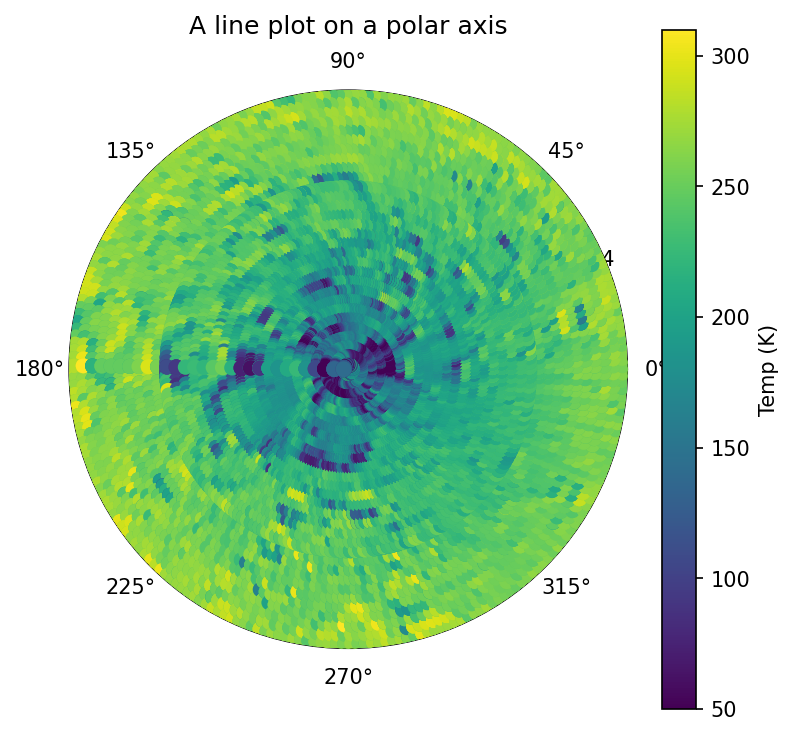

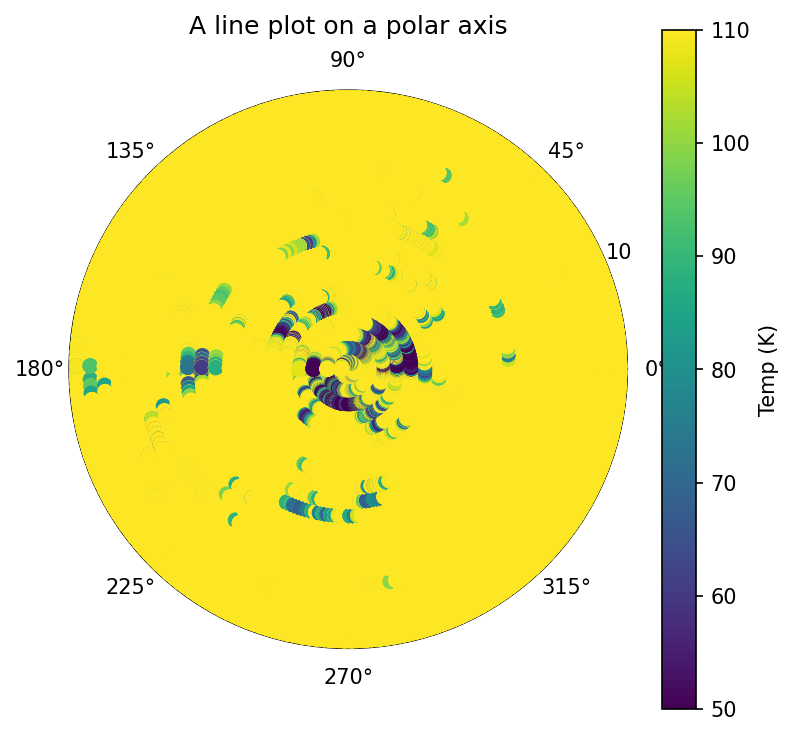

In [5]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6), dpi=150)
sz = 0.5*(latitude[mask_tod])

#plt.plot(longitude[mask_tod], 90-latitude[mask_tod], '.')
cbar = ax.scatter(np.deg2rad(longitude[mask_tod]), 90-latitude[mask_tod], c=temp, cmap='viridis', s=sz, vmin=50, vmax=310, zorder=10)
ax.set_rmax(15)
#ax.set_rticks([90, 89.5, 89, 88.5])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
#ax.grid(True)
ax.set_title("A line plot on a polar axis", va='bottom')
plt.colorbar(cbar, label="Temp (K)")
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6), dpi=150)
sz = 0.5*(latitude[mask_tod])

#plt.plot(longitude[mask_tod], 90-latitude[mask_tod], '.')
cbar = ax.scatter(np.deg2rad(longitude[mask_tod]), 90-latitude[mask_tod], c=temp, cmap='viridis', s=sz, vmin=50, vmax=110, zorder=10)
ax.set_rmax(10)
#ax.set_rticks([90, 89.5, 89, 88.5])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
#ax.grid(True)
ax.set_title("A line plot on a polar axis", va='bottom')
plt.colorbar(cbar, label="Temp (K)")
plt.show()


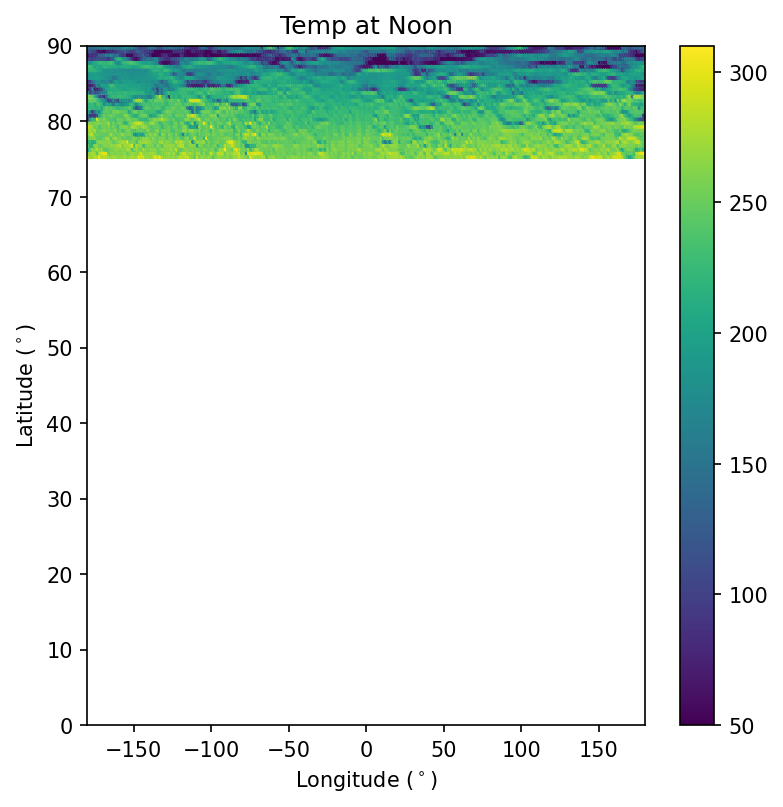

In [6]:
plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(longitude[mask_tod], latitude[mask_tod], c=temp, cmap='viridis', s=1, vmin=50, vmax=310)
plt.xlabel("Longitude ($^\circ$)")
plt.xlim((-180, 180))
plt.ylabel("Latitude ($^\circ$)")
plt.ylim((0, 90))
plt.colorbar()
plt.title("Temp at Noon")
plt.show()

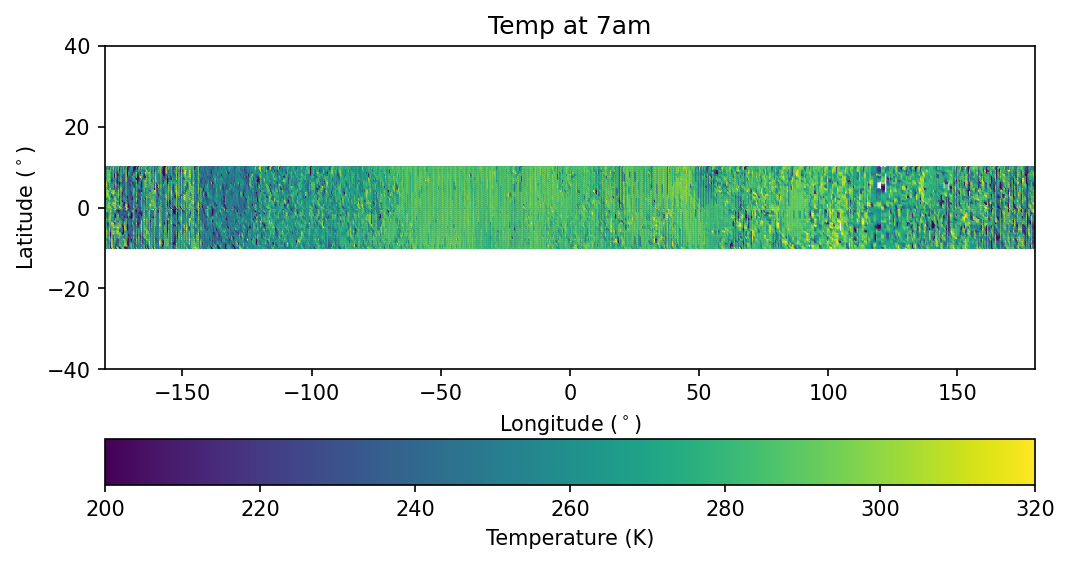

In [35]:
mask = (np.abs(pr.data[:, :, 1]) < 10) & (pr.data[:, :, 0] % 0.25 == 0) # latitude and long limited
latitude = pr.data[:, :, 1][mask]
longitude = pr.data[:, :, 0][mask]

mask_tod = (pr.data[mask, 2] < 7.5) & (pr.data[mask, 2] > 6.5)
tod = pr.data[mask, 2][mask_tod]
temp = pr.data[:, :, -1][mask][mask_tod]

plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(longitude[mask_tod], latitude[mask_tod], c=temp, cmap='viridis', s=1, vmin=200, vmax=320)
plt.xlabel("Longitude ($^\circ$)")
plt.xlim((-180, 180))
plt.ylabel("Latitude ($^\circ$)")
plt.ylim((-40, 40))
plt.colorbar(label='Temperature (K)', orientation="horizontal")
plt.title("Temp at 7am")
plt.show()

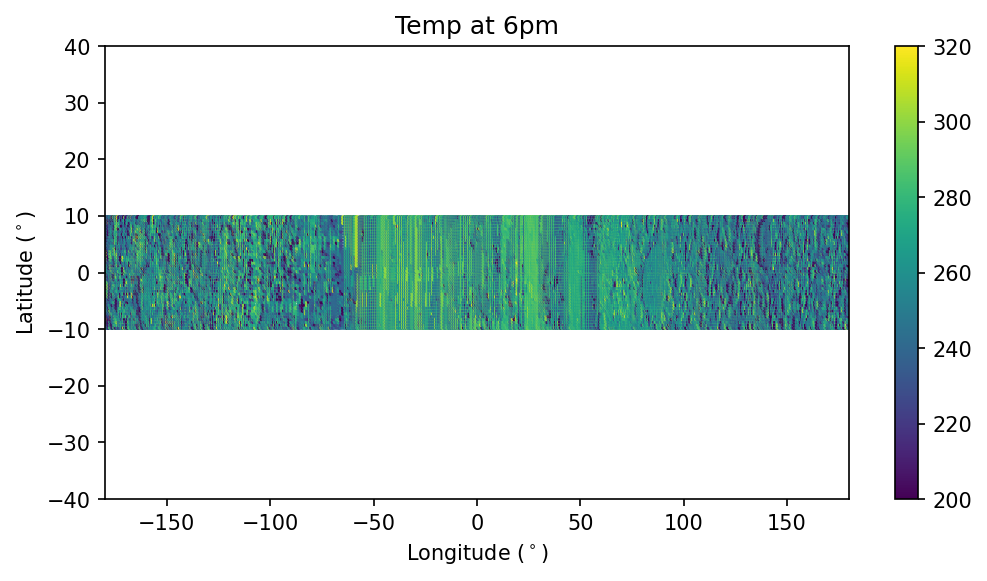

In [31]:
mask = (np.abs(pr.data[:, :, 1]) < 10) & (pr.data[:, :, 0] % 0.25 == 0) # latitude and long limited
latitude = pr.data[:, :, 1][mask]
longitude = pr.data[:, :, 0][mask]

mask_tod = (pr.data[mask, 2] < 17.5) & (pr.data[mask, 2] > 16.5)
tod = pr.data[mask, 2][mask_tod]
temp = pr.data[:, :, -1][mask][mask_tod]

plt.figure(figsize=(8, 4), dpi=150)
#plt.scatter(longitude[mask_tod], latitude[mask_tod], c=temp, cmap='viridis', s=1, vmin=200, vmax=400)
plt.scatter(longitude[mask_tod], latitude[mask_tod], c=temp, cmap='viridis', s=1, vmin=np.nanmin(200), vmax=np.nanmax(320))
plt.xlabel("Longitude ($^\circ$)")
plt.xlim((-180, 180))
plt.ylabel("Latitude ($^\circ$)")
plt.ylim((-40, 40))
plt.colorbar()
plt.title("Temp at 6pm")
plt.show()

In [2]:
def ballistic(temp, i_lat, i_long, i_tod, direction, launch, pMass, vel_dist):
    # note, as some point, we should take the weighted average, rather than max. 
    s1 = maxwell_boltz_dist(vel_dist, pMass, temp)
    particle_v = random.choices(vel_dist, weights=s1/np.nanmax(s1))[0]
    dist_m = ballistic_distance(launch, moonR, particle_v, moonM)
    f_lat, f_long = landing_loc(i_lat, i_long, dist_m, moonR, direction)
    f_tod = time_of_day(i_long, f_long, i_tod)
    f_tof = ballistic_tof(particle_v, launch)
    return f_lat, f_long, f_tod, f_tof, dist_m


def Model_full(Temperature, tod, Latitude, Longitude, sigma_Sputtering, photo_lifespan, pMass, data):
    # pMass is 
    R_bar = R/(m_H2O/1000)
    Pv = clapyeron(triple_P, triple_T, R_bar, Lc, Temperature)
    direction, launch = random_vals()
    cond = False
    i=0
    f_lat, f_long, f_tod, f_tof,  distm = ballistic(Temperature, Latitude, Longitude, tod, direction, launch, pMass, vel_dist)
    dist_tot = distm
    tof_tot = f_tof
    while cond == False:
        cond1 = sputtering_prob(sigma_Sputtering, f_tof)
        cond2 = photodestruction_inflight_prob(photo_lifespan, f_tof)
        Pv = clapyeron(triple_P, triple_T, R_bar, Lc, Temperature)
        cond3 = sublimation_surf(Pv, Temperature, pMass*Avo)*Gyr_E <= 0.1*density_H2O # 0.1 m/Gyr
        cond = np.any((cond1, cond2, cond3))
        direction, launch = random_vals()
        Temperature = DivinerT(f_lat, f_long, f_tod, 0.75, data)
        f_lat, f_long, f_tod, f_tof, dist_m = ballistic(Temperature, f_lat, f_long, f_tod, direction, launch, pMass, vel_dist)
        i+=1
        dist_tot += distm
        tof_tot +=f_tof

    return i, f_lat, f_long, f_tod, dist_tot, tof_tot

sz = 10
num = np.zeros((sz))*np.nan
out = np.zeros((sz, 6))*np.nan
# num[i], f_lat, f_long, f_tod, dist_tot, tof_tot
for i in range(0,sz):
    out[i, :] = pr.Model_full(393, 12, 0, 0, pr.sput_lifespan_G19, pr.photo_lifespan_S14, pr.mass, pr.data)
    print("%2.0f/%2.0f"%(i,sz))

plt.hist(out[:, 0])#label="num")
plt.ylabel('Number of runs it occurs for')
plt.xlabel('number of hops')
plt.show()

/Users/laferrierek/Box Sync/Desktop/Research/Moon_Transport/Codes/processes_lib.py:495: RuntimeWarning: Mean of empty slice
  Tmean = np.nanmean(T)
/Users/laferrierek/Box Sync/Desktop/Research/Moon_Transport/Codes/processes_lib.py:288: RuntimeWarning: All-NaN slice encountered
  particle_v = vel_dist[int(np.argwhere(np.nanmax(s1)==s1))]


(9,)


TypeError: only size-1 arrays can be converted to Python scalars

625 [561]
74.0 1812.0 707.55 299.9363490809342


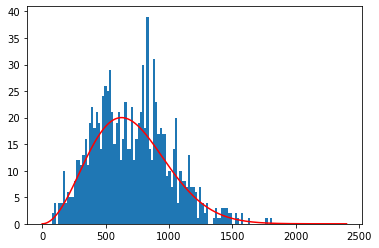

2375.5063077277223
[]
5.921625441284444e-05
99.99976019970246


In [10]:
# particle velocity
T = 400
pMass = (pr.m_OH/1000) /pr.Avo #pr.mass
vel_dist = np.arange(0, 2400)
s1 = pr.maxwell_boltz_dist(vel_dist, pMass, T)
particle_v = vel_dist[int(np.argwhere(np.nanmax(s1)==s1))]
particle_v_weight = random.choices(vel_dist, weights=s1)
print(particle_v, particle_v_weight)
#plt.plot(vel_dist, 20*s1/np.nanmax(s1), c='r')


steps = 1000
test = np.zeros((steps))*np.nan
for i in range(steps):
    test[i] = random.choices(vel_dist, weights=s1/np.nanmax(s1))[0]
print(np.nanmin(test), np.nanmax(test), np.nanmean(test), np.std(test))
#plt.plot(np.arange(0, 2000, 2000/steps), test,'.', c='r')
plt.plot(vel_dist, (steps/1000)*20*s1/np.nanmax(s1), c='r')
plt.hist(test, bins=100)
plt.show()

print(pr.vesc)
print(np.argwhere(test >= pr.vesc))
print(np.sum(s1[np.argwhere(vel_dist >= pr.vesc)])*100)
print(np.sum(s1[np.argwhere(vel_dist <= pr.vesc)])*100)

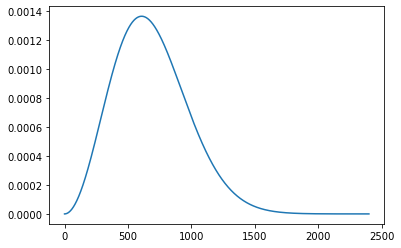

0.999999224194298
2.7239967440652924e-07


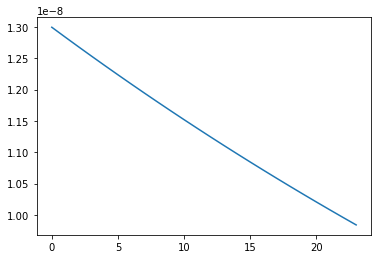

In [9]:
T = 400
pMass = (pr.m_H2O/1000) /pr.Avo #pr.mass
vel_dist = np.arange(0, 2400)
s1 = pr.maxwell_boltz_dist(vel_dist, pMass, T)

plt.plot(vel_dist, s1)
plt.show()

print(np.sum(s1))
print(np.sum(s1[np.argwhere(vel_dist>=pr.vesc)]))
plt.plot(s1[np.argwhere(vel_dist>=pr.vesc)])

In [7]:
print(s1, s1[-1], s1[1])


[0.00000000e+00 2.03585606e-08 8.14331838e-08 ... 2.53481437e-09
 2.49380380e-09 2.45343424e-09] 2.453434244191675e-09 2.035856061153384e-08


In [3]:
# Plot model run results - histogram. how many jumps is common for a molecule, starting at noon subsolar
sz = 10
num = np.zeros((sz))*np.nan
out = np.zeros((sz, 6))*np.nan
# num[i], f_lat, f_long, f_tod, dist_tot, tof_tot
for i in range(0,sz):
    out[i, :] = pr.Model_full(393, 12, 0, 0, pr.sput_lifespan_G19, pr.photo_lifespan_S14, pr.mass, pr.data)
    print("%2.0f/%2.0f"%(i,sz))

plt.hist(out[:, 0])#label="num")
plt.ylabel('Number of runs it occurs for')
plt.xlabel('number of hops')
plt.show()

KeyboardInterrupt: 

In [1]:
# Plot the locations of where it goes per step
Latitude = np.deg2rad(0)
Longitude = np.deg2rad(180)
tod = 10
Temperature = pr.DivinerT(Latitude, Longitude, tod, 0.75, pr.data)
pMass = pr.mass
sigma_Sputtering = 1/pr.sput_rate_G19
direction, launch = pr.random_vals()
cond = False
i=0

R_bar = pr.R/(pr.m_H2O/1000)
Pv = pr.clapyeron(pr.triple_P, pr.triple_T, R_bar, pr.Lc, Temperature)
f_lat, f_long, f_tod, f_tof,  distkm = pr.ballistic(Temperature, Latitude, Longitude, tod, direction, launch, pMass, pr.vel_dist)
plt.figure(figsize=(5,5), dpi=150)
plt.scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c='k', s=30)
while cond == False:
    cond1 = pr.sputtering_prob(sigma_Sputtering, f_tof)
    cond2 = pr.photodestruction_inflight_prob(pr.photo_lifespan_S14, f_tof)
    cond3 = pr.sublimation_surf(Pv, Temperature, pMass*pr.Avo)*pr.Gyr_E < 0.1*pr.density_H2O
    cond = np.any((cond1, cond2, cond3))

    direction, launch = pr.random_vals()
    Temperature = pr.DivinerT(f_lat, f_long, f_tod, 0.75, pr.data)
    f_lat, f_long, f_tod, f_tof, distkm = pr.ballistic(Temperature, f_lat, f_long, f_tod, direction, launch, pMass, pr.vel_dist)
    Pv = pr.clapyeron(pr.triple_P, pr.triple_T, R_bar, pr.Lc, Temperature)

    cr=plt.scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c=f_tod, cmap='coolwarm', vmin=0, vmax=24, s=15)
    i+=1
    
        
plt.scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c='r', marker='x', s=10)
#plt.ylim((-90, 90))
plt.ylabel('Latitude')
#plt.xlim((-180, 180))
plt.xlabel('Longitude')
plt.title('Single particle transport, %2.0f jumps'%i)
plt.colorbar(cr, label='Time of day')
plt.show()

print(f_tod)
    

NameError: name 'np' is not defined

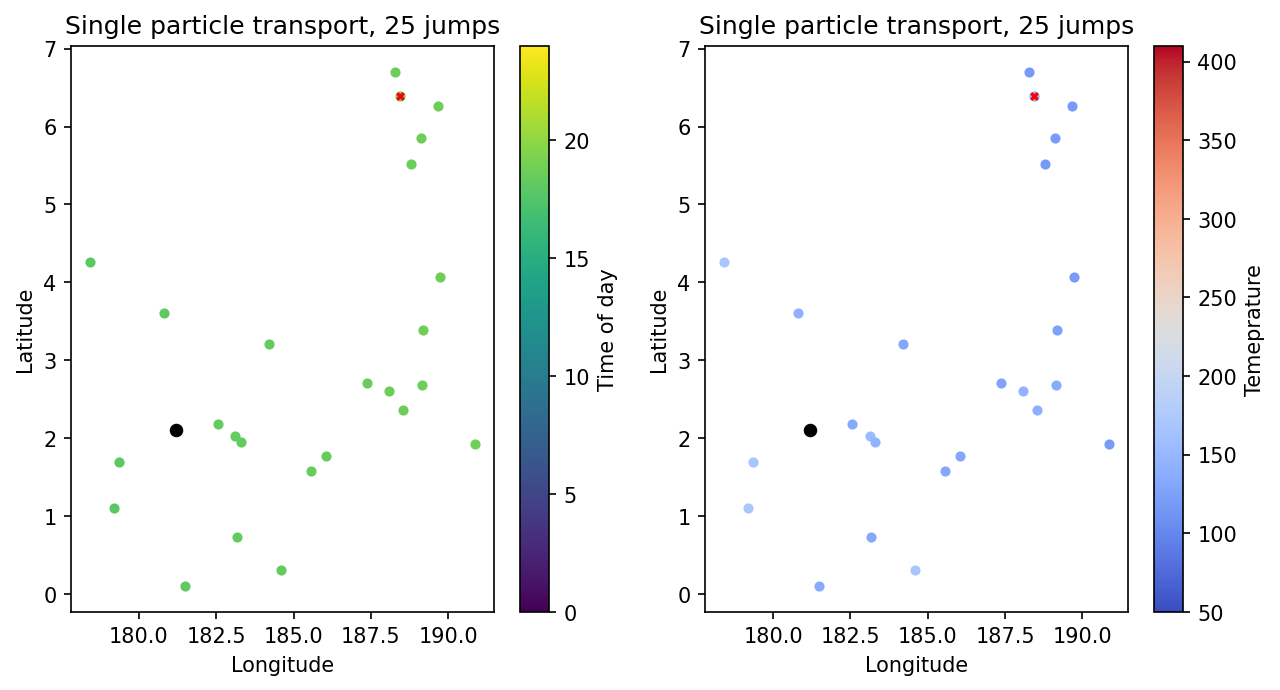

18.634669694062616 137.19425833333332


In [18]:
# Plot the locations of where it goes per step
Latitude = np.deg2rad(0)
Longitude = np.deg2rad(180)
tod = 18
Temperature = pr.DivinerT(Latitude, Longitude, tod, 0.75, pr.data)
pMass = pr.mass
sigma_Sputtering = 1/pr.sput_rate_G19
direction, launch = pr.random_vals()
cond = False
i=0

R_bar = pr.R/(pr.m_H2O/1000)
Pv = pr.clapyeron(pr.triple_P, pr.triple_T, R_bar, pr.Lc, Temperature)
f_lat, f_long, f_tod, f_tof,  distkm = pr.ballistic(Temperature, Latitude, Longitude, tod, direction, launch, pMass, pr.vel_dist)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), dpi=150)
ax2.scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c='k', s=30)
ax1.scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c='k', s=30)

while cond == False:
    cond1 = pr.sputtering_prob(sigma_Sputtering, f_tof)
    cond2 = pr.photodestruction_inflight_prob(pr.photo_lifespan_S14, f_tof)
    cond3 = pr.sublimation_surf(Pv, Temperature, pMass*pr.Avo)*pr.Gyr_E < 0.1*pr.density_H2O
    cond = np.any((cond1, cond2, cond3))

    direction, launch = pr.random_vals()
    Temperature = pr.DivinerT(f_lat, f_long, f_tod, 0.75, pr.data)
    f_lat, f_long, f_tod, f_tof, distkm = pr.ballistic(Temperature, f_lat, f_long, f_tod, direction, launch, pMass, pr.vel_dist)
    Pv = pr.clapyeron(pr.triple_P, pr.triple_T, R_bar, pr.Lc, Temperature)

    cr=ax1.scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c=f_tod, cmap='viridis', vmin=0, vmax=24, s=15)
    cm=ax2.scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c=Temperature, cmap='coolwarm', vmin=50, vmax=410, s=15)

    i+=1
    
        
ax1.scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c='r', marker='x', s=10)
#ax1.set_ylim((-90, 90))
ax1.set_ylabel('Latitude')
#ax1.set_xlim((0, 360))
ax1.set_xlabel('Longitude')
ax1.set_title('Single particle transport, %2.0f jumps'%i)
plt.colorbar(cr, label='Time of day', ax=ax1)

ax2.scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c='r', marker='x', s=10)
#ax2.set_ylim((-90, 90))
ax2.set_ylabel('Latitude')
#ax2.set_xlim((0, 360))
ax2.set_xlabel('Longitude')
ax2.set_title('Single particle transport, %2.0f jumps'%i)
plt.colorbar(cm, label='Temeprature', ax=ax2)
plt.show()


print(f_tod, Temperature)

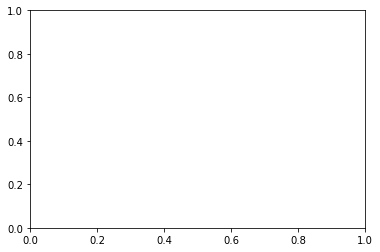

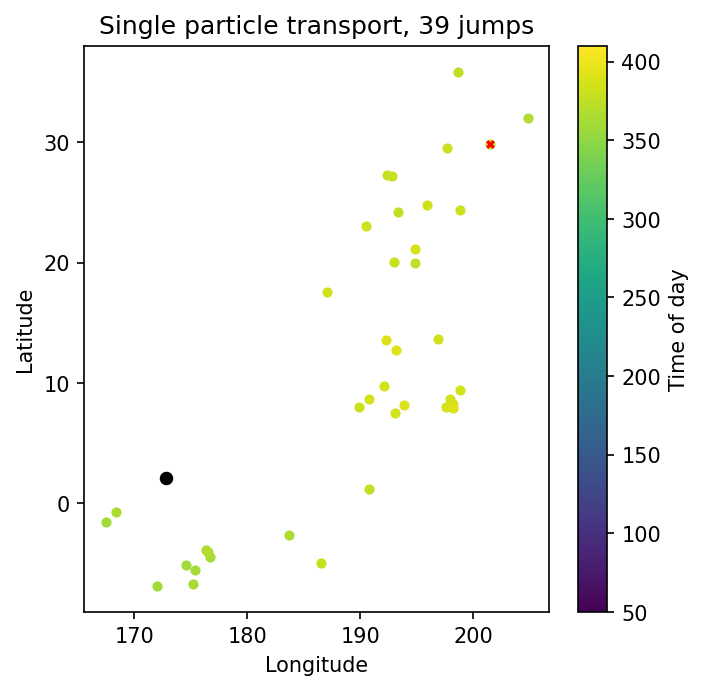

11.565821876925067


In [2]:
# Plot the locations of where it goes per step - color is temp
Latitude = np.deg2rad(0)
Longitude = np.deg2rad(180)
tod = 10
Temperature = pr.DivinerT(Latitude, Longitude, tod, 0.75, pr.data)
pMass = pr.mass
sigma_Sputtering = 1/pr.sput_rate_G19
direction, launch = pr.random_vals()
cond = False
i=0

R_bar = pr.R/(pr.m_H2O/1000)
Pv = pr.clapyeron(pr.triple_P, pr.triple_T, R_bar, pr.Lc, Temperature)
f_lat, f_long, f_tod, f_tof,  distkm = pr.ballistic(Temperature, Latitude, Longitude, tod, direction, launch, pMass, pr.vel_dist)
plt.figure(figsize=(5,5), dpi=150)
plt.scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c='k', s=30)
while cond == False:
    cond1 = pr.sputtering_prob(sigma_Sputtering, f_tof)
    cond2 = pr.photodestruction_inflight_prob(pr.photo_lifespan_S14, f_tof)
    cond3 = pr.sublimation_surf(Pv, Temperature, pMass*pr.Avo)*pr.Gyr_E < 0.1*pr.density_H2O
    cond = np.any((cond1, cond2, cond3))

    direction, launch = pr.random_vals()
    Temperature = pr.DivinerT(f_lat, f_long, f_tod, 0.75, pr.data)
    f_lat, f_long, f_tod, f_tof, distkm = pr.ballistic(Temperature, f_lat, f_long, f_tod, direction, launch, pMass, pr.vel_dist)
    Pv = pr.clapyeron(pr.triple_P, pr.triple_T, R_bar, pr.Lc, Temperature)

    cr=plt.scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c=Temperature, cmap='viridis', vmin=50, vmax=410, s=15)
    i+=1
    
        
plt.scatter(np.rad2deg(f_long), np.rad2deg(f_lat), c='r', marker='x', s=10)
#plt.ylim((-90, 90))
plt.ylabel('Latitude')
#plt.xlim((-180, 180))
plt.xlabel('Longitude')
plt.title('Single particle transport, %2.0f jumps'%i)
plt.colorbar(cr, label='Time of day')
plt.show()

print(f_tod)

In [19]:
# test to make sure theres no time of day dependence that shouldn't be there
# have one particle jump until destroyed. initiate from same spot, different times
def test_tod_dep(lat, long, stat):
    sz = 23
    num = np.zeros((sz, stat))*np.nan
    final_lat = np.zeros((sz, stat))*np.nan
    final_lon = np.zeros((sz, stat))*np.nan
    final_tod = np.zeros((sz, stat))*np.nan
    total_dist = np.zeros((sz, stat))*np.nan
    total_tof = np.zeros((sz, stat))*np.nan
    for i in range(0,sz):
        for j in range(0, stat):
            t_i = pr.DivinerT(0, 0, i, 0.75, pr.data)
            num[i, j], final_lat[i, j], final_lon[i, j], final_tod[i, j], total_dist[i, j], total_tof[i, j] = pr.Model_full(t_i, i, 0, np.pi/2, pr.sput_lifespan_G19,pr.photo_lifespan_S14, pr.mass, pr.data)
        print("%2.0f/%3.0f"%(i, sz))
    return num, final_lat, final_lon, final_tod, total_dist, total_tof

num, final_lat, final_lon, final_tod, total_dist, total_tof = test_tod_dep(0, 0, 5)


#for i in range(0,sz):
#    t_i = pr.DivinerT(0, 0, i, 0.75, pr.data)
#    num[i], final_lat[i], final_lon[i], final_tod[i], total_dist[i], total_tof[i] = pr.Model_full(t_i, i, 0, np.pi/2, pr.sput_lifespan_G19,pr.photo_lifespan_S14, pr.mass, pr.data)
#    if i % 10 == 0:
#        print("%2.0f/%3.0f"%(i, sz))


 0/ 23
 1/ 23
 2/ 23
 3/ 23
 4/ 23
 5/ 23
 6/ 23
 7/ 23
 8/ 23
 9/ 23
10/ 23
11/ 23
12/ 23
13/ 23
14/ 23
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/laferrierek/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/8b/58p6cy2n6_5dxsjpc6f4kp580000gn/T/ipykernel_24591/1156472241.py", line 18, in <cell line: 18>
    num, final_lat, final_lon, final_tod, total_dist, total_tof = test_tod_dep(0, 0, 5)
  File "/var/folders/8b/58p6cy2n6_5dxsjpc6f4kp580000gn/T/ipykernel_24591/1156472241.py", line 14, in test_tod_dep
    num[i, j], final_lat[i, j], final_lon[i, j], final_tod[i, j], total_dist[i, j], total_tof[i, j] = pr.Model_full(t_i, i, 0, np.pi/2, pr.sput_lifespan_G19,pr.photo_lifespan_S14, pr.mass, pr.data)
  File "/Users/laferrierek/Box Sync/Desktop/Research/Moon_Transport/Codes/processes_lib.py", line 533, in Model_full
    sub = sublimation_surf(Pv, Temperature, pMass*Avo)
  File "/Users/laferrierek/Box Sync/Desktop/Research/Moon_Transport/Codes/processes_lib.py", line 4

In [2]:
tod = np.arange(0, 23)

plt.figure(figsize=(6,4), dpi=100)
plt.scatter(tod, num[:, 0], c='r', alpha=0.5, s=1)
plt.scatter(tod, num[:, 1], c='r', alpha=0.5, s=2)
plt.scatter(tod, num[:, 2], c='r', alpha=0.5, s=3)
plt.errorbar(tod, np.nanmean(num[:, :], axis=1), yerr=np.std(num, axis=1), c='k', alpha=1, fmt='.', capsize=3)
plt.ylabel('Number of jumps')
plt.xlabel("Time of day (hr)")
plt.show()

flat = np.rad2deg(final_lat)
plt.figure(figsize=(6,4), dpi=100)
plt.scatter(tod, flat[:, 0], c='r', alpha=0.5, s=1)
plt.scatter(tod, flat[:, 1], c='r', alpha=0.5, s=2)
plt.scatter(tod, flat[:, 2], c='r', alpha=0.5, s=3)
plt.errorbar(tod, np.nanmean(flat[:,:], axis=1), yerr=np.std(flat, axis=1), c='k', alpha=1, fmt='.', capsize=3)
plt.ylabel('Final lat')
plt.xlabel("Time of day (hr)")
plt.show()

#plt.scatter(np.arange(0, 23), np.rad2deg(final_lon))
#plt.ylabel('final long')
#plt.xlabel("Time of day (hr)")
#plt.show()

plt.figure(figsize=(6,4), dpi=100)
plt.scatter(tod, final_tod[:, 0], c='r', alpha=0.5, s=1)
plt.scatter(tod, final_tod[:, 1], c='r', alpha=0.5, s=2)
plt.scatter(tod, final_tod[:, 2], c='r', alpha=0.5, s=3)
plt.errorbar(tod, np.nanmean(final_tod[:,:], axis=1), yerr=np.std(final_tod, axis=1), c='k', alpha=1, fmt='.', capsize=3)
#plt.scatter(np.arange(0, 23), final_tod)
plt.ylabel('Final tod')
plt.xlabel("Time of day (hr)")
plt.show()

tdist = total_dist
plt.figure(figsize=(6,4), dpi=100)
plt.scatter(tod, tdist[:, 0], c='r', alpha=0.5, s=1)
plt.scatter(tod, tdist[:, 1], c='r', alpha=0.5, s=2)
plt.scatter(tod, tdist[:, 2], c='r', alpha=0.5, s=3)
plt.errorbar(tod, np.nanmean(tdist[:,:], axis=1), yerr=np.std(tdist, axis=1), c='k', alpha=1, fmt='.', capsize=3)
#plt.scatter(np.arange(0, 23), total_dist)
plt.ylabel('total dist')
plt.xlabel("Time of day (hr)")
plt.show()

ttof = total_tof
plt.figure(figsize=(6,4), dpi=100)
plt.scatter(tod, ttof[:, 0], c='r', alpha=0.5, s=1)
plt.scatter(tod, ttof[:, 1], c='r', alpha=0.5, s=2)
plt.scatter(tod, ttof[:, 2], c='r', alpha=0.5, s=3)
plt.errorbar(tod, np.nanmean(ttof[:,:], axis=1), yerr=np.std(ttof, axis=1), c='k', alpha=1, fmt='.', capsize=3)
#plt.scatter(np.arange(0, 23), total_tof)
plt.ylabel('total tof (s)')
plt.xlabel("Time of day (hr)")
plt.show()

ttof = total_tof/pr.sec_per_hour_M
plt.figure(figsize=(6,4), dpi=100)
plt.scatter(tod, ttof[:, 0], c='r', alpha=0.5, s=1)
plt.scatter(tod, ttof[:, 1], c='r', alpha=0.5, s=2)
plt.scatter(tod, ttof[:, 2], c='r', alpha=0.5, s=3)
plt.errorbar(tod, np.nanmean(ttof[:,:], axis=1), yerr=np.std(ttof, axis=1), c='k', alpha=1, fmt='.', capsize=3)
#plt.scatter(np.arange(0, 23), total_tof)
plt.ylabel('total tof (hr)')
plt.xlabel("Time of day (hr)")
plt.show()

NameError: name 'np' is not defined

ValueError: x and y must be the same size

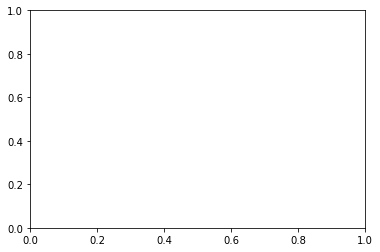

In [7]:
# plot the num of jumps vs tod - check tod dependence
plt.scatter(np.arange(0, 23), num)
plt.ylabel('Number of jumps')
plt.xlabel("Time of day (hr)")
plt.show()

plt.scatter(np.arange(0, 23), np.rad2deg(final_lat))
plt.ylabel('Final lat')
plt.xlabel("Time of day (hr)")
plt.show()

plt.scatter(np.arange(0, 23), np.rad2deg(final_lon))
plt.ylabel('final long')
plt.xlabel("Time of day (hr)")
plt.show()

plt.scatter(np.arange(0, 23), final_tod)
plt.ylabel('Final tod')
plt.xlabel("Time of day (hr)")
plt.show()

plt.scatter(np.arange(0, 23), total_dist)
plt.ylabel('total dist')
plt.xlabel("Time of day (hr)")
plt.show()

plt.scatter(np.arange(0, 23), total_tof)
plt.ylabel('total tof')
plt.xlabel("Time of day (hr)")
plt.show()

In [12]:
# Considering the same starting position/tod/temp, where do the particles go?
sz = 100
num = np.zeros((sz))*np.nan
final_lat = np.zeros((sz))*np.nan
final_lon = np.zeros((sz))*np.nan
final_tod = np.zeros((sz))*np.nan
total_dist = np.zeros((sz))*np.nan
total_tof = np.zeros((sz))*np.nan
for i in range(0,sz):
    num[i], final_lat[i], final_lon[i], final_tod[i], total_dist[i], total_tof[i] = pr.Model_full(270, 6, 0, np.pi/2, pr.sput_lifespan_G19,pr.photo_lifespan_S14, pr.mass, pr.data)
    if i % 10 == 0:
        print("%2.0f/%3.0f"%(i, sz))



 0/100


KeyboardInterrupt: 

In [ ]:
# plot, each run is semi-random - prove it visually.
cr=plt.scatter(np.rad2deg(final_lon), np.rad2deg(final_lat), c=final_tod, cmap='viridis', vmin=0, vmax=24, s=15)
plt.scatter(np.rad2deg(final_lon[-1]), np.rad2deg(final_lat[-1]), c='r', marker='x', s=10)
#plt.scatter(np.rad2deg(final_lon), np.rad2deg(final_lat), c='k',alpha=0.5)
plt.scatter(np.rad2deg(np.pi/2), 0, c='orange', s=10)
#plt.ylim((-90, 90))
plt.ylabel('Latitude')
#plt.xlim((-180, 180))
plt.xlabel('Longitude')
plt.title('%2.0f particle transports'%i)
plt.colorbar(cr, label='Time of day')
plt.show()

In [2]:
final_T = pr.DivinerT(np.rad2deg(final_lat), np.rad2deg(final_lon), final_tod, 0.5, pr.data)

plt.hist(final_T)
plt.show()

NameError: name 'final_lat' is not defined

In [ ]:
# plot histograms, show randomness

plt.hist(total_dist/1000)
plt.ylabel('Number of runs it occurs for')
plt.xlabel('distance traveled (total km)')
plt.show()

plt.hist(final_tod)
plt.ylabel('Number of runs it occurs for')
plt.xlabel('Landing time of day (hr)')
plt.show()

plt.hist(np.rad2deg(final_lat))
plt.ylabel('Number of runs it occurs for')
plt.xlabel('final lat')
plt.show()

plt.hist(np.rad2deg(final_lon), range=[0, 360])
plt.ylabel('Number of runs it occurs for')
plt.xlabel('final long')
plt.show()

#plt.scatter(final_dist/1000, total_dist/1000)
#plt.ylabel('Total distance ')
#plt.xlabel('Final distance')
#plt.show()

plt.hist(total_tof/(60*60))
plt.ylabel('Number of runs it occurs for')
plt.xlabel('total time of flight (Earth hours)')
plt.show()

print(np.min(np.rad2deg(final_lon)), np.max(np.rad2deg(final_lon)))

In [ ]:
# this is made to run and test changes visually, so read in the methods files you made in spyder
import numpy as np
import matplotlib.pyplot as plt
import ballistic_basics as bm
import processes_lib as pr

# Constants
Avo = 6.0221*10**(23)   # 1/ mol
G = 6.6741*10**(-11)      # m3/kg/s2
kb = 1.38064*10**(-23)  #J/K

# Molecules
m_H2O= 18.01528         # g/ mol
m_OH = 17.008           # g/mol
mass = (m_H2O/1000) / Avo # kg/mol / (1/mol)

# what does time mean?
# a lunar day is 29.53 days on Earth
sec_per_day_E = 24*60*60
sec_per_day_M = sec_per_day_E * 29.53
sec_per_hour_M = sec_per_day_M/24
sec_per_min_M = sec_per_hour_M/60

# Moon
moonM = 7.3477*10**22     # kg
moonR = 1738.1*10**3    # m
Lunar_rad = 1738.1 # equatorial radius, km
rev = 27.3217 # roation period, Earth days

In [ ]:
# Firstly, lets see what happens when we only consider ballistic transport
landing_lat, landing_long, landing_time, flighttime, vel, dist = pr.ballistic(T, lat, long, tod, angle, launch_angle, pMass, vel_dist)

# Print values
print("Starting location: [%2.2f N, %2.2f E]"%(np.rad2deg(lat), np.rad2deg(long)))
print("Landing location: [%2.2f N, %2.2f E]"%(np.rad2deg(landing_lat), np.rad2deg(landing_long)))
print('Flight time: %2.2f s'%flighttime)
print("Particle velocity: %3.0f m/s"%vel)


In [ ]:
# Next, what if we consider loss to sputtering?


In [ ]:
# Now, incorporate sublimation




In [ ]:
# Now, incorporate photodestruction

 


In [ ]:
# Now, incorporate diffusion

In [ ]:
# Single run, given latitude, longitude, tod. 
T_int = pr.DivinerT(0, 0, 12, 0.5, pr.data)
num, landing_lat, landing_lon, landing_tod, total_dist, total_tof = Model_full(T_int, 12, 0, 0, sput_lifespan_G19, photo_lifespan_S14, mass, surfT)
dist_land = haversine(0, 0, landing_lon, landing_lat, moonR)
print("Number of jumps: ", num)
print(r"Landing Location: %2.1f, %2.1f N"%( landing_lon, landing_lat))
print("Total distance vs distance from start: %2.1f vs %2.1f km"%(total_dist/1000, dist_land/1000))
print("Total time in flight: %2.1f s"%total_tof)
print("Percent of time in air (of a lunar hour) %3.2f: "%(total_tof/sec_per_hour_M))
print('Temperature at landing point: %3.0f K'%(DivinerT(landing_lat, landing_lon, landing_tod, 0.5, surfT)) )


In [5]:
# how long does it take to run, does it depend on initial position
import time
st = time.time()
sz = 10

for j in range(0, 90, 10):
    lat = j
    long = 0
    tod = 12
    Temp = pr.DivinerT(np.deg2rad(lat), long, tod, 0.75, pr.data)
    dif = np.zeros((10))
    for i in range(0,sz):
        st_r = time.time()
        pr.Model_full(Temp, tod, np.deg2rad(lat), long, pr.sput_lifespan_G19, pr.photo_lifespan_S14, pr.mass, pr.data)
        en = time.time()
        dif[i] = en-st_r
    print("Time avg for lat %1.0f N: %2.0f s +/- %2.1f"%(j, np.nanmean(dif), np.std(dif)))
    print("Max: %2.0f s, Min: %2.0f s"%(np.nanmax(dif), np.nanmin(dif)))
print("Time for total: %2.0f s"%(time.time()-st))


(4,)
(9,)
(18,)
(18,)
(18,)
(9,)
(9,)


/Users/laferrierek/Box Sync/Desktop/Research/Moon_Transport/Codes/processes_lib.py:494: RuntimeWarning: Mean of empty slice
  Tmean = np.nanmean(T)
/Users/laferrierek/Box Sync/Desktop/Research/Moon_Transport/Codes/processes_lib.py:287: RuntimeWarning: All-NaN slice encountered
  particle_v = vel_dist[int(np.argwhere(np.nanmax(s1)==s1))]


(9,)


TypeError: only size-1 arrays can be converted to Python scalars

In [3]:
import processes_lib as pr
import numpy as np
lat = np.deg2rad(85)
long = 0
tod = 12

def DivinerT(lat_R, long_R, tod, delta, data):
    lat = np.rad2deg(lat_R)
    long = np.rad2deg(long_R - np.pi) 
    
    masklong = (data[:, :, 0] > long - delta) & (data[:, :, 0] < long+delta)
    masklat = (data[:, :, 1] > lat - delta) & (data[:, :, 1] < lat+delta)
    masktod = (data[:, :,  2] > tod - delta/2) & (data[:, :, 2] < tod+delta/2)
        
    row = masklong*masklat*masktod
    if np.any(row) != True:
        print(lat)
        raise Exception("Lacking lat data")
    else: 
       T = data[row, 10]
       Tmean = np.nanmean(T)

    #print(np.shape(T), T)
    return Tmean #, n

Temp = DivinerT(np.deg2rad(lat), long, tod, 0.5, pr.data)


(4,) [     nan 388.8989      nan 389.9237]


389.4113

In [ ]:
e = 0.87

T = 200
t = 10**(-13)*np.exp((e*1.602*10**(-19)*0.5)/(pr.kb*T))
print("%2.2f"%t, "0.01 s")

T = 150
t = 10**(-13)*np.exp((e*1.602*10**(-19)*0.5)/(pr.kb*T))
print("%2.1f"%t, "30 s")

T = 125
t = 10**(-13)*np.exp((e*1.602*10**(-19)*0.5)/(pr.kb*T))
print("%2.1e"%t, "10^4 s")

T = 100
t = 10**(-13)*np.exp((e*1.602*10**(-19)*0.5)/(pr.kb*T))
print("%2.1e"%t, "10^9 s")

e = 0.95

T = 350
t = 10**(-13)*np.exp((e*1.602*10**(-19)*0.9)/(pr.kb*T))
print("%2.2f"%t, "< 1 s")

T = 350
t = 10**(-13)*np.exp((e*1.602*10**(-19)*1.2)/(pr.kb*T))
print("%2.1f"%t, " > 1000 s")

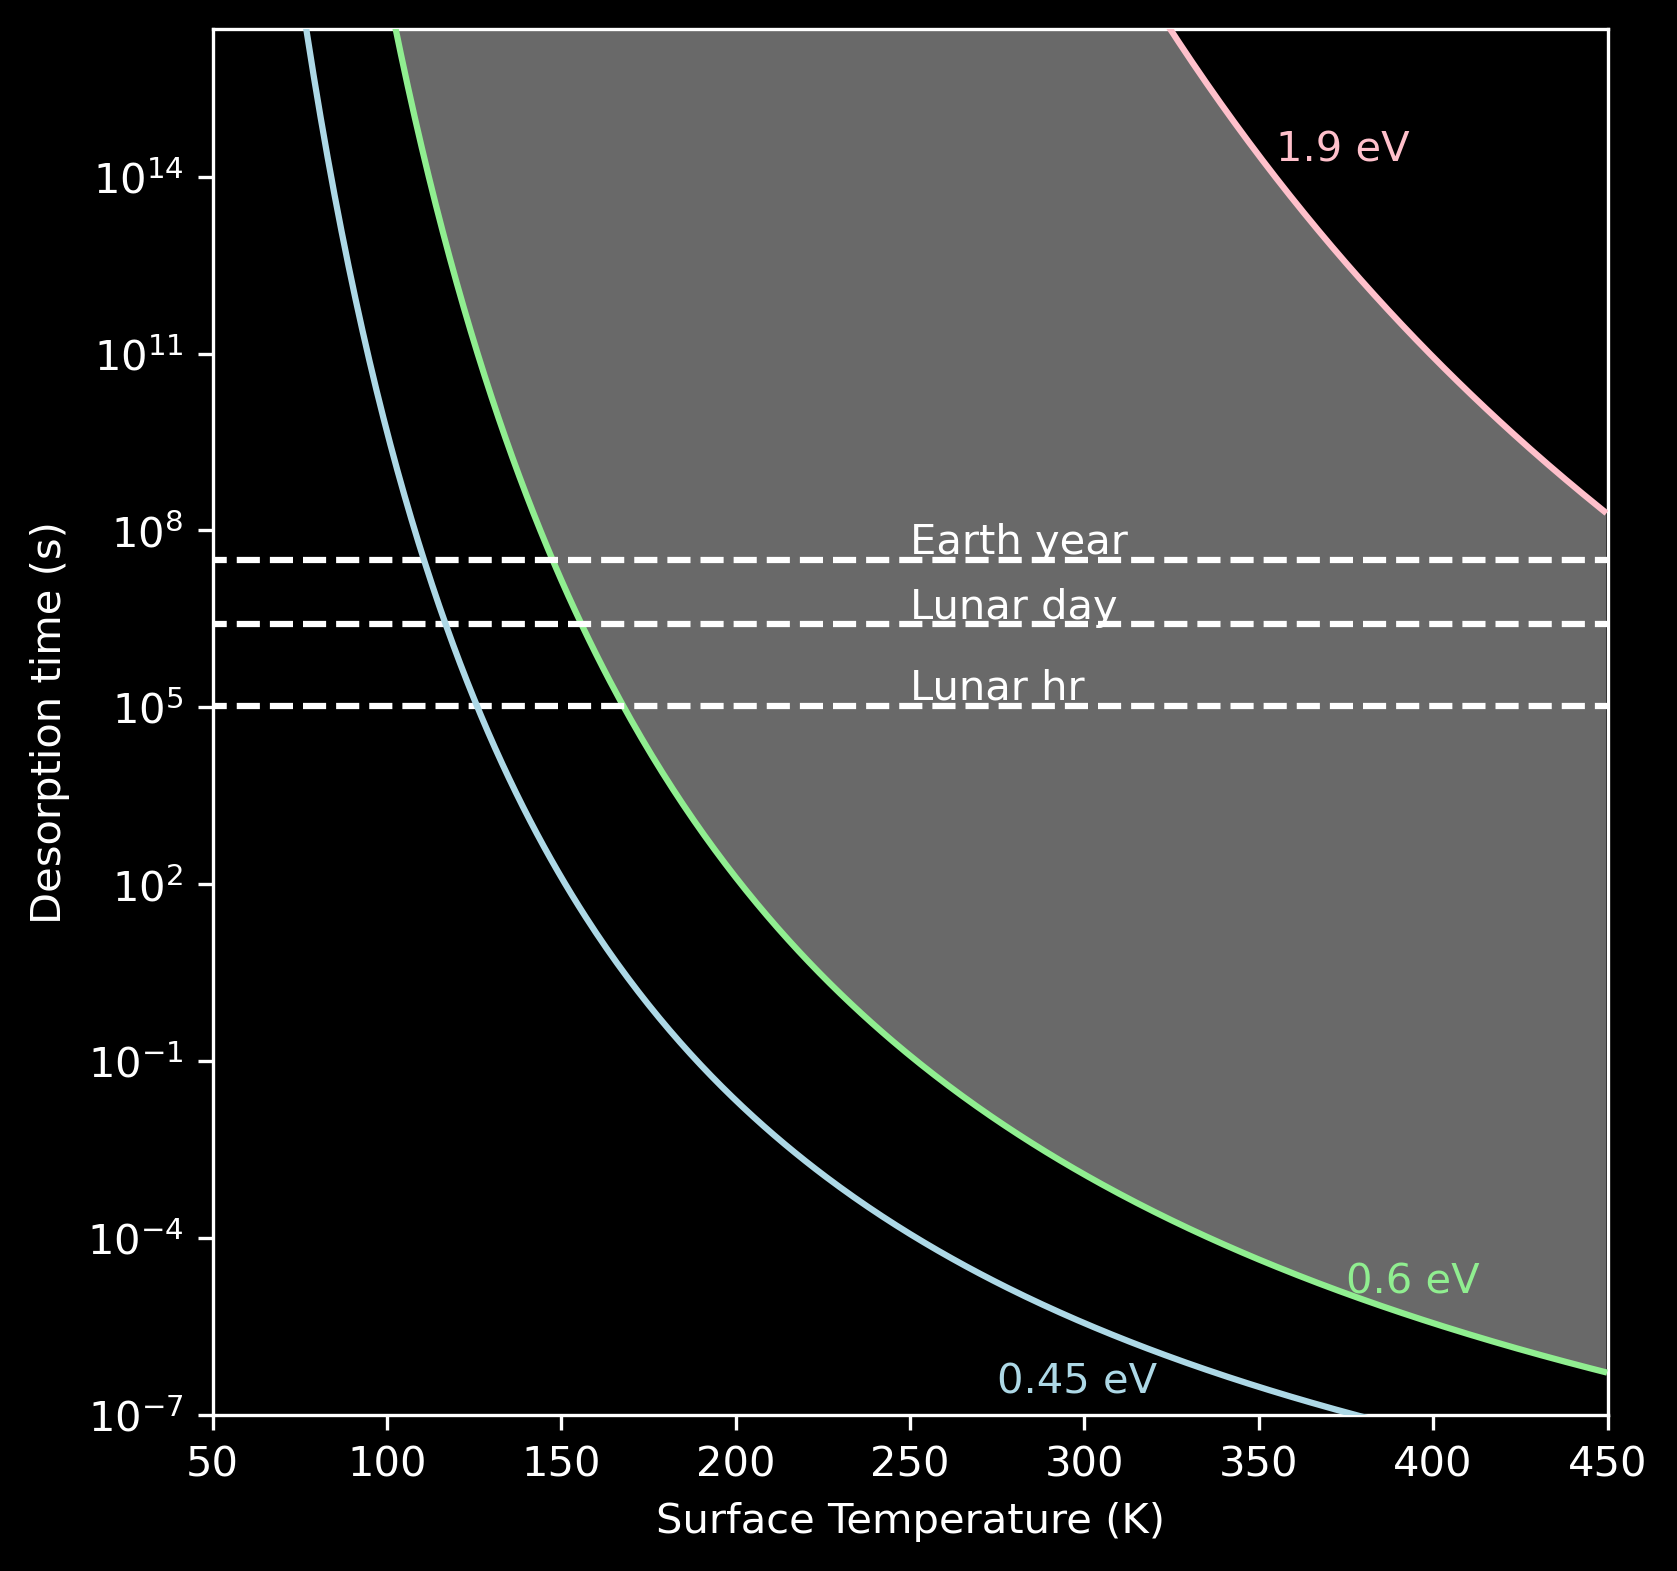

In [16]:
# test desorption timescale
plt.style.use('dark_background')
test_T = np.arange(50, 450, 1)

R_bar = pr.R/(pr.m_OH/1000)
pMass = pr.mass    

Pv = pr.clapyeron(pr.triple_P, pr.triple_T, R_bar, pr.Lc, test_T)
sub = pr.sublimation_surf(Pv, test_T, pMass*pr.Avo) # kg/m2/s

perc_mono = 0.01
theta_mon = 10**19 * perc_mono
tau_sub = (theta_mon * pMass) / sub


desorp_loweV = pr.desorption_R21(test_T, 0.45)
desorp_medeV = pr.desorption_R21(test_T, 0.6)
desorp_F15eV = pr.desorption_F15(test_T, 0.6, 10**(-7))

desorp_higheV = pr.desorption_R21(test_T, 1.9)
#plt.style.use('default')
plt.figure(figsize=(6, 6), dpi=300)
plt.plot(test_T, desorp_loweV, c='lightblue', label='0.45 eV', zorder=10)
plt.annotate("0.45 eV", (test_T[-100]-75, desorp_loweV[-100]*0.8), c='lightblue', zorder=9)
plt.plot(test_T, desorp_medeV, c='lightgreen', label='0.6 eV', zorder=5)
plt.annotate("0.6 eV", (test_T[-80]+5, desorp_medeV[-80]*0.8), c='lightgreen', zorder=9)

#plt.plot(test_T, tau_sub, c='purple', label='sublimation', zorder = 8)
#plt.annotate("Sublimation", (test_T[120]-75, tau_sub[120]*0.8), c='purple')
#plt.plot(test_T, desorp_F15eV, c='orange', label='0.6 eV', zorder=5)

plt.plot(test_T,desorp_higheV, c='pink', label='1.9 eV', zorder=10)
plt.annotate("1.9 eV", (test_T[-100]+5, desorp_higheV[-100]*0.8), c='pink', zorder=9)

plt.fill_between(test_T, desorp_medeV, desorp_higheV, color='dimgray', zorder=2)

#plt.hlines(pr.Gyr_E, 0, 450, color='k')
#plt.annotate("Second in Gyr", (60,pr.Gyr_E))

plt.hlines(pr.sec_per_day_E*365.25, 0, 450, color='w', linestyle='dashed', zorder=5)
plt.annotate("Earth year", (250,pr.sec_per_day_E*365.25*1.3))
plt.hlines(pr.sec_per_day_M, 0, 450, color='w', linestyle='dashed', zorder=5)
plt.annotate("Lunar day", (250,pr.sec_per_day_M*1.3))
plt.hlines(pr.sec_per_hour_M, 0, 450, color='w', linestyle='dashed', zorder=5)
plt.annotate("Lunar hr", (250, pr.sec_per_hour_M*1.3))
plt.yscale('log')
plt.ylim((10**(-7), pr.Gyr_E))
plt.xlim((50, 450))
plt.ylabel("Desorption time (s)")
plt.xlabel("Surface Temperature (K)")
#plt.legend()
plt.show()


In [13]:
import numpy as np

T = 300
E_des = 0.6 #eV
kb = 1.38064*10**(-23)              # J/K
k = kb/(1.60218*10**(-19))
R_des = 10**(13) * np.exp(-E_des/(k*T))
tau = 1/R_des

# new equation for desorption
n_g = 2*10**4 # gas density, molecules/cm3
v_g = 500 # mean gas speed
t_res = 100000 # surfacec residence time
Cads = n_g * v_g*t_res # adsorbate coverage
print('%3.2e'%Cads, 'expected:  %2.3e'%(10**12))

sigma = 10**(-15) #cm2, cross section of adsorbate

second_order_desorb = 0.25*R_des*sigma*Cads
print(second_order_desorb)

second_order_desorb = 0.25*R_des*sigma*10**13
print(second_order_desorb)
# Hendrix et al. (2019) -> 10^13 molecules/cm2

1.00e+12 expected:  1.000e+12
0.20811182420180546
2.0811182420180545
